# Experiment 1.4
Testing orange and brown at the final pool layer.

Carrying on from experiment 1.3. We will repeat the idea of 1.3, but chop off the output side of the network to expose the pre-pooled activations. This is a process of increasing the resolution that we are investigating.

This experiment shows that the Cx7x7 activations reaching the pool layer carry enough information for _poor but not terrible_ accuracy at a 7x7 resolution to detect the difference between orange and brown. The experiment setup might be contributing to poor accuracy, so it's not appropriate to conclude an accuracy upper bound.

In [1]:
import cv2
import numpy as np
from enum import Enum
import colorsys
import moviepy.editor as mpe
import moviepy
from typing import *
import random
import pandas as pd
import json
import torch
from icecream import ic
import nncolor as nc
import nncolor.data
import torchinfo
import torchvision as tv
import torchvision.datasets
import torchvision.models
import torchvision.transforms
import torch.nn
import torch.optim
import time
import copy
import os
import torch.hub
from collections import namedtuple
import ipyplot
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
presentation_mode = True
md_export_mode = False
if presentation_mode:
    import warnings
    warnings.filterwarnings('ignore')
    mpl.rcParams.update({'font.size': 20})
    mpl.rcParams.update({'axes.labelsize': 20})
    mpl.rcParams.update({'text.usetex': False})

In [3]:
import IPython
def imshow(img):
    """Show image. 
    
    Image is a HWC numpy array with values in the range 0-1."""
    img = img*255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # cv2 imencode takes images in HWC dimension order.
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i) 
    
    
def imlist(images, labels=None, use_tabs=False):
    if md_export_mode:
        print("Skipping ipyplot image print for markdown export. The output"
              " produces HTML that either Jupyter Lab fails to export correctly,"
              " or Hugo fails to render correctly. Skipping for now.")
        return
    if use_tabs:
        ipyplot.plot_class_tabs(images, labels, max_imgs_per_tab=300)
    else:
        ipyplot.plot_images(images, labels)

## 1. Notebook constants
Variables used as constants throughout the notebook.

In [4]:
# Choose CPU or GPU.
device = torch.device('cuda:0')
#device = "cpu"

# Choose small or large (standard) model variant
#model_name = "resnet18"
model_name = 'resnet50'
def model_fctn():
    if model_name == 'resnet18':
        return tv.models.resnet18(pretrained=True)
    elif model_name == 'resnet50':
        return tv.models.resnet50(pretrained=True)
resnet_model = model_fctn()

GRID_SHAPE = (7, 7)
NUM_CELLS = np.prod(GRID_SHAPE)
IMG_SHAPE = (224, 224, 3)
cell_shape = nc.data.cell_shape(GRID_SHAPE, IMG_SHAPE)
assert np.array_equal(cell_shape, (32, 32))
# Choosing a diameter less than cell width/height.
# Let's go with 20 (so radius is 10)
RADIUS = 10
BATCH_SIZE = 4
NUM_FC_CHANNELS = 512 if model_name == 'resnet18' else 2048

## 2. Model (resnet)
First, let's double check the model summary.

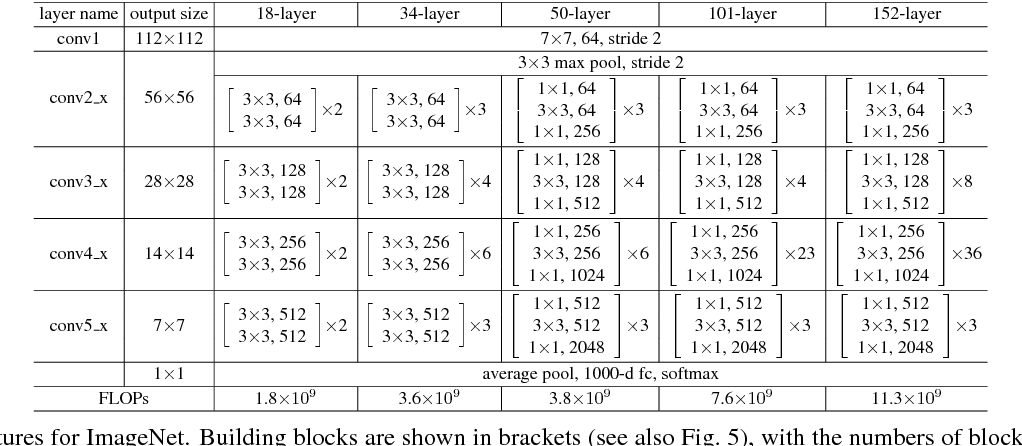

Another model visualization can be seen  at: 
http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006

In [5]:
torchinfo.summary(resnet_model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

## 3. Dataset
The dataset generation code has been moved out into a Python package, `nncolor`. Below, we 
take a moment to investigate the data.

First, recall the 4 color classes we are dealing with, and the numbers they are mapped to.

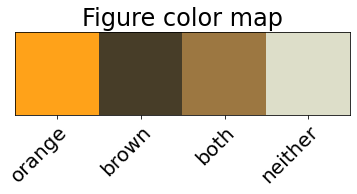

In [6]:
nc.data.color_legend();

Below is a movie clip cycling through some of the image-label pairs that will be generated.

In [7]:
def demo_data():
    FPS = 2
    frames, labels = nc.data.create_samples(30, radius=RADIUS, grid_shape=GRID_SHAPE, 
                                            img_shape=IMG_SHAPE)
    frames = [f*255 for f in frames]
    x_clip = mpe.ImageSequenceClip(frames, fps=2)
    y_clip = mpe.TextClip('WB-0', font='DejaVu-Sans')

    class FrameText(mpe.VideoClip):
        def __init__(self, text, fps):
            def make_frame(f):
               return mpe.TextClip(text[int(f)], font='DejaVu-Sans', color='white').get_frame(f)
            self.duration = 1.0 * len(text) / fps
            mpe.VideoClip.__init__(self, make_frame=make_frame, duration=self.duration)

    y_clip =   FrameText(labels, FPS)
    label_clip = mpe.CompositeVideoClip([mpe.ImageClip(np.zeros(nc.data.DEFAULT_IMG_SHAPE), duration=5), y_clip])
    comp_clip = mpe.clips_array([[y_clip],[x_clip]])
    return comp_clip
clip = demo_data() 
clip.ipython_display(rd_kwargs={'logger':None})

In [8]:
color_counts = [ (nc.data.COLOR_ID_TO_LABEL[idx], nc.data.exp_1_1_data.loc[lambda r:r['ans'] == idx, :].shape[0]) for idx in range(nc.data.NUM_CLASSES)]
ic(color_counts)

ic| color_counts: [('orange', 39), ('brown', 29), ('both', 3), ('neither', 148)]


[('orange', 39), ('brown', 29), ('both', 3), ('neither', 148)]

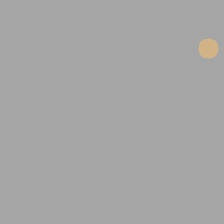

ic| sample['label']: 0
ic| sample['label_grid']: array([[3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 0],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3]])
ic| sample['position']: 13


In [9]:
def test_dataset():
    train, test, val = nc.data.train_test_val_split(nc.data.exp_1_1_data_filtered, 
                                      RADIUS, GRID_SHAPE, IMG_SHAPE)
    sample = val[7]
    imshow(sample['image'])
    ic(sample['label'])
    ic(sample['label_grid'])
    ic(sample['position'])
test_dataset()

## 4. Customize the model
We want to have a model with the fully connected layer removed, and for that, it seems easiest to subclass and override.

In [10]:
class PoolHeadResNet(tv.models.ResNet):
    def __init__(self, train_all_params=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        num_classes = nc.data.NUM_CLASSES
        # First, disable all other parameters.
        if not train_all_params:
            for param in self.parameters():
                param.requires_grad = False
        # A 1x1 convolution, representing effectively a fully connected, sub-batched at 7x7.
        self.fc2 = torch.nn.Conv2d(in_channels=NUM_FC_CHANNELS, out_channels=num_classes, kernel_size=1,stride=1)
        
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # Stop above.
        #x = self.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.fc(x)
        x = self.fc2(x)
        return x
    
train_all_params = True
edited_resnet_model = None
if model_name == 'resnet18':
    edited_resnet_model = PoolHeadResNet(train_all_params, tv.models.resnet.BasicBlock, [2, 2, 2, 2])
elif model_name == 'resnet50':
    edited_resnet_model = PoolHeadResNet(train_all_params, tv.models.resnet.Bottleneck, [3, 4, 6, 3])
else:
    raise Exception('Not supported')
state = torch.hub.load_state_dict_from_url(tv.models.resnet.model_urls[model_name])
edited_resnet_model.load_state_dict(state, strict=False);

### 4.1 Modified model summary
The modified model can be seen to have a final layer with output shape [Batch, 4, 7, 7] representing 7x7 individual 4-class classification outputs.

In [11]:
torchinfo.summary(edited_resnet_model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
PoolHeadResNet                           --                        --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

### 4.2 Check that initialization of the new layer
Double check that our new layer has been initialized

In [12]:
edited_resnet_model.fc2.weight[0][0:10]

tensor([[[ 0.0058]],

        [[ 0.0216]],

        [[-0.0157]],

        [[-0.0036]],

        [[ 0.0074]],

        [[-0.0075]],

        [[-0.0143]],

        [[-0.0210]],

        [[-0.0022]],

        [[ 0.0069]]], device='cuda:0', grad_fn=<SliceBackward>)

All looks good! Now design the loss function.

## 5. Loss function
The best loss function to use is not obvious. On one extreme, we can weight all 49 outputs equally as 49 equal predictions to which we apply cross entropy loss. However, this will heavily weight the model caring only about the background, which is always a "3" for neither orange or brown. Alternatively, we could weight only the activation mapped to the dot position. A loss that is a balance of these extremes is also possible.

I try the two extreme losses. I also try two weighted losses that sit in the middle.

### 5.1 Equal weighting
We can extend the MLE/cross-entropy loss used in the previous experiment. If we treat each of the 49 (7x7) outputs as a classification output, then each forward pass now involves 49 different results that form a sort of "sub-batch". We need to take care that our use of the standard loss function is working correctly with this increased output dimension. Below is a brief demo of how the API can be used to achieve the correct result.
The `CrossEntropyLoss` function luckily supports multidimensional input/outputs in the way I need:

In [13]:
# Tesing out a loss function
# 4x2x2 (smaller test version of our 7x7x4).
fc_in = torch.tensor([# batch
    [ # 4x2x2
        [[-0.3, 0.0], [0.3, 3.2] ], # 2x2
        [[ 4.0, 0.1], [-4., 1.1] ], # 2x2
        [[ 7.0, 0.4], [2.0, -.4] ], # 2x2
        [[ 2.1, 4.1], [2.2, 4.1] ], # 2x2
    ]
], dtype=torch.float)
target = torch.tensor([ # batch
    [[0, 1], [1, 1]] # 2x2
], dtype=torch.long)
# We can view all 4 classification losses:
loss = torch.nn.CrossEntropyLoss(reduction='none') 
output = loss(fc_in, target)
ic(output)
# Or we can reduce them to a single number.
loss = torch.nn.CrossEntropyLoss(reduction='mean') 
output = loss(fc_in, target)
ic(output)

ic| output: tensor([[[7.3563, 4.0579],
                     [6.8782, 3.3835]]])
ic| output: tensor(5.4190)


tensor(5.4190)

As a loss function, the 49 sub-batch MLE loss is implemented like below. The extra `pos` and `mask` arguments as the later loss functions use these extra arguments.

In [14]:
def mle(input_, target, pos, mask):
    """Loss function where each output unit is a classification."""
    return torch.nn.functional.cross_entropy(input_, target, reduction='mean')

### 5.2 MLE loss (background-foreground balance weighting)
This weighting gives the 48 units associated with the background a weighting of 1 and gives the
the single unit associated with the dot a weighting of 48.

When an equal weighting is used, the model can get an accuracy of about 48/49 if it always classifies all of the 49 outputs as "neither". This loss tries to correct for this issue. 

In [15]:
def mle_balanced(input_, target, pos, mask):
    """48 weight for the dot-cell, 1 weight for each 48 background 48 cells.""" 
    loss = torch.nn.functional.cross_entropy(input_, target, reduction='none')
    loss_weight = torch.mul(mask, NUM_CELLS - 2) + torch.ones(mask.shape).to(device)
    loss = torch.mul(loss, loss_weight)
    loss = torch.mean(loss)
    return loss

### 5.3 Dot only
This loss is a MLE loss that only considers the output unit that is associated with the
dot position. All other outputs are ignored. 

An obvious issue with this loss is that there is no incentive for the model to correctly
classify the background color. This is a loss that should give the model great leniency 
towards maximizing accuracy of the dot color classification at the expense of the background
color classification.

In [16]:
def mle_dot(input_, target, pos, mask):
    """MLE loss considering only the output unit associated with the dot position."""
    loss = torch.nn.functional.cross_entropy(input_, target, reduction='none')
    dot_loss = torch.mul(mask, loss) 
    dot_loss = torch.mean(loss)
    return dot_loss

### 5.3 MLE loss (radial weighted) 
MLE loss for each of the 49 outputs, with the loss weighted based on the distance to the dot. This is like the first loss above, except we have introduced a more complex weighting function.


In [17]:
# Cache the computation of radial loss weighting. This is used
# in the below loss function.
radial_loss = nc.data.radial_weight_for_every_pos(GRID_SHAPE, max_dist=5, 
                                                rate_fctn=nc.data.ease_in_out_sine)
radial_loss[np.array([0,4])].shape
radial_loss = torch.from_numpy(radial_loss).to(device)

def mle_radial(input_, target, pos, mask):
    loss = torch.nn.functional.cross_entropy(input_, target, reduction='none')
    loss_weight = radial_loss[pos]
    dot_loss = torch.mul(loss_weight, loss) 
    dot_loss = torch.mean(loss)
    return dot_loss

## 6. Training
Training loop.

In [18]:
# Copied from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Data augmentation and normalization
normalize_transform =  tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# tv.transforms.ToTensor will swap the dimensions from HWC to CHW
to_CHW_tensor_transform = tv.transforms.ToTensor()
data_transform = tv.transforms.Compose([to_CHW_tensor_transform, normalize_transform])
train_ds, test_ds, val_ds = nc.data.train_test_val_split(nc.data.exp_1_1_data_filtered,
                                                        dot_radius=RADIUS,
                                                        grid_shape=GRID_SHAPE)
val_ds.transform = data_transform
train_ds.transform = data_transform
# Don't transform the test dataset. We need to visualize the images without them being normalized.
test_ds.transform = to_CHW_tensor_transform
ds = {'train': train_ds, 'val': val_ds, 'test': test_ds}
dataloaders = {x: torch.utils.data.DataLoader(ds[x], batch_size=BATCH_SIZE, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(ds[x]) for x in ['train', 'val', 'test']}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        # For this experimentation, the validation isn't that useful, 
        # as the measure of accuracy we are interested is quite complex.
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_dot_corrects = 0

            # Iterate over data.
            #for inputs, labels in dataloaders[phase]:
            for batch in dataloaders[phase]:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)
                label_grids = batch['label_grid'].to(device)
                mask_grids = batch['mask_grid'].to(device)
                pos = batch['position'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, label_grids, pos, mask_grids)
                    # backward + optimize only if in training phase
                    #l2_reg = 0
                    #for param in model.fc2.parameters():
                    #    l2_reg += torch.norm(param)
                    #loss += 0.01 * l2_reg
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                pred_correct = preds == label_grids.data
                pred_dot_correct = torch.mul(pred_correct, mask_grids)
                running_corrects += torch.sum(pred_correct)
                running_dot_corrects += torch.sum(pred_dot_correct)
            if phase == 'train':
                scheduler.step()

            denom = dataset_sizes[phase] * NUM_CELLS
            epoch_loss = running_loss / denom
            epoch_acc = running_corrects.double() / denom
            epoch_dot_acc = running_dot_corrects / dataset_sizes[phase]

            print('{} Loss: {:.5f} Acc: {:.5f} Dot Acc: {:.5f}'.format(
                phase, epoch_loss, epoch_acc, epoch_dot_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    # NO! should be model with least loss
    #model.load_state_dict(best_model_wts)
    return model

## 7. Investigate model
To explore the nature of the predictions, I want an array with dimensions (label, prediction) and values are tallies. Accuracy for each label is then the diagonal divided by the sum along the prediction dimension. Overall accuracy is the sum along the diagonal divided by the complete sum. 

## 7.1 Model accuracy 
Below is some code that was used to test out how to implement this. 

In [19]:
def _test_code():
    acc = torch.zeros((4,4), dtype=torch.long)
    res, label = [torch.rand((2, 4, 7, 7)), 
                  torch.randint(0, 4, (2, 7, 7))]
    norml = torch.sum(res, dim=1)
    norml = norml.unsqueeze(1)
    res = res / norml
    _, p = torch.max(res, 1)
    label = torch.flatten(label)
    p = torch.flatten(p)
    # put_ requires linear indexes, which is a bit strange.
    # https://pytorch.org/docs/master/generated/torch.Tensor.put_.html#torch.Tensor.put_
    linear_indexes = label*4 + p 
    ones = torch.LongTensor([1]).expand_as(linear_indexes)
    return acc.put_(linear_indexes, ones, accumulate=True)
_test_code()

tensor([[ 4,  7,  7,  9],
        [11,  3,  7,  9],
        [ 4,  0,  5,  9],
        [ 5, 11,  5,  2]])

The actual accuracy investigation code is implemented below.

In [24]:
def test_model(model):
    model.eval()
    accuracy = None
    dot_accuracy = None
    dot_tally_grid = torch.zeros(GRID_SHAPE).to(device)
    accuracy_details = torch.zeros((nc.data.NUM_CLASSES, nc.data.NUM_CLASSES)).to(device)
    dot_accuracy_details = torch.zeros((nc.data.NUM_CLASSES, nc.data.NUM_CLASSES)).to(device)
    ones = torch.ones(BATCH_SIZE*NUM_CELLS, dtype=torch.float).to(device)
    dot_ones = torch.ones(BATCH_SIZE, dtype=torch.float).to(device)
    for batch in dataloaders['test']:
        images = batch['image']
        inputs = normalize_transform(images).to(device)
        labels = batch['label'].to(device)
        pos = batch['position'].to(device)
        mask_grids = batch['mask_grid'].to(device)
        label_grids = batch['label_grid'].to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Grid tallying correct dot predictions
        dot_tally_grid += torch.sum((preds == label_grids)*mask_grids, dim=0)
        
        # Accuracy breakdown for all units. 
        labelf = torch.flatten(label_grids)
        #labelf = torch.full((BATCH_SIZE, *GRID_SHAPE, nc.data.LABEL_TO_COLOR_ID['neither'])
        predf = torch.flatten(preds)
        linear_indexes = labelf * nc.data.NUM_CLASSES + predf
        accuracy_details.put_(linear_indexes, ones, accumulate=True)
        
        # Dot accuracy breakdown.
        dot_predf = torch.gather(torch.flatten(preds, 1, -1), 1,torch.unsqueeze(pos, -1))
        dot_predf = torch.squeeze(dot_predf)
        linear_indexes = labels * nc.data.NUM_CLASSES + dot_predf
        dot_accuracy_details.put_(linear_indexes, dot_ones, accumulate=True)
        
    tally = torch.sum(accuracy_details, dim=1)
    tally = tally.unsqueeze(1)
    accuracy_details_norm = accuracy_details / tally
    
    tally = torch.sum(dot_accuracy_details, dim=1)
    tally = tally.unsqueeze(1)
    dot_accuracy_details_norm = dot_accuracy_details / tally
        
    def print_acc_array(arr: np.ndarray, title=''):
        labels = nc.data.COLOR_ID_TO_LABEL.keys()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_title(title)
        cax = ax.imshow(arr, cmap='viridis', vmin=0.0, vmax=1.0)
        fig.colorbar(cax)
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.set_ylabel('actual color')
        ax.set_xlabel('predicted color')
        plt.show()
    print_acc_array(accuracy_details_norm.cpu().numpy(), "Test set confustion matrix")
    print_acc_array(dot_accuracy_details_norm.cpu().numpy(), "Test set confustion matrix\n(dot positions only)")
    print("Test set confusion matrix data:")
    print(accuracy_details_norm)
    print("Test set confusion matrix data (dot positions only):")
    print(dot_accuracy_details_norm)
    print("Test set unnormalized confusion matrix data:")
    print(accuracy_details)
    print("Test set unnormalized confusion matrix data (dot positions only):")
    print(dot_accuracy_details)
    print("Grid tallying correct dot predictions")
    print(dot_tally_grid)

## 7.2 Debug specific samples
The following methods are used to check how a model behaves for a specific image. 

In [21]:
def debug_img(model, img):
        input_ = torch.unsqueeze(normalize_transform(img), 0).to(device)
        output = model(input_)
        ans = torch.argmax(output, 1)[0]
        ans = ans.cpu().detach().numpy()
        img = img.numpy().swapaxes(0, -1)
        # cv2 draw has some issues if numpy arrays are not continuous,
        # and to fix spurious issues, copying seems to work.
        im_print = img.copy()
        #im_print *= 255
        nc.data.draw_overlay(im_print, ans)
        return im_print

    
def showfilter(model):
    filter_len = 512 if model_name == 'resnet18' else 2048
    cut_size = 128
    cuts = int(filter_len / cut_size)
    for i in range(cuts):
        w = model.fc2.weight.cpu().detach().numpy()
        w = np.squeeze(w)
        plt.matshow(w[:,i*cut_size:(i+1)*cut_size])
        plt.title(f'Fully-connected layer filter. Block part {i}/{cuts}')
        
        
def debug_model(model):
    showfilter(model)
    # 3: hard
    # 9: blank
    # 10: orange
    # 14: easy, but machine performs poorly.
    interesting_samples = [test_ds[i] for i in (3, 8, 9, 10, 12, 13, 14, 17)]
    #ic(val_ds[0]['image'].shape)
    images = []
    labels = []
    print('Interesting examples:')
    for s in interesting_samples:
        im = debug_img(model, s['image'])
        images.append(im)
        labels.append(s['label'])
    imlist(images, labels)
    
    print('Other examples:')
    print("(Tab by correct label. The grids are the model outputs)")
    num_samples = 50
    images, labels = zip(*map(lambda s: (debug_img(model, s['image']), s['label']), 
                              (test_ds[s] for s in range(num_samples))))
    imlist(images, labels, use_tabs=True)

### 8. Run Experiment. 
Train one of two models (resnet18 or resnet50) with 4 types of losses with gradient descent. Test the accuracy of each model-loss pair.

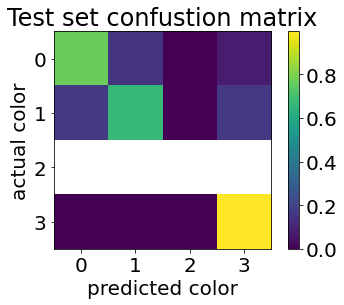

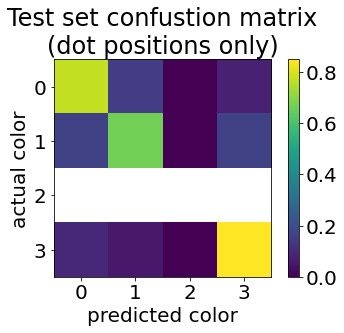

Test set confusion matrix data:
tensor([[7.6923e-01, 1.5385e-01, 0.0000e+00, 7.6923e-02],
        [1.6667e-01, 6.6667e-01, 0.0000e+00, 1.6667e-01],
        [       nan,        nan,        nan,        nan],
        [1.4249e-03, 8.7239e-04, 0.0000e+00, 9.9770e-01]], device='cuda:0')
Test set confusion matrix data (dot positions only):
tensor([[0.7692, 0.1538, 0.0000, 0.0769],
        [0.1667, 0.6667, 0.0000, 0.1667],
        [   nan,    nan,    nan,    nan],
        [0.0943, 0.0578, 0.0000, 0.8479]], device='cuda:0')
Test set unnormalized confusion matrix data:
tensor([[4.9000e+02, 9.8000e+01, 0.0000e+00, 4.9000e+01],
        [4.9000e+01, 1.9600e+02, 0.0000e+00, 4.9000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.4500e+02, 1.5000e+02, 0.0000e+00, 1.7155e+05]], device='cuda:0')
Test set unnormalized confusion matrix data (dot positions only):
tensor([[ 490.,   98.,    0.,   49.],
        [  49.,  196.,    0.,   49.],
        [   0.,    0.,    0.,    0.],
    

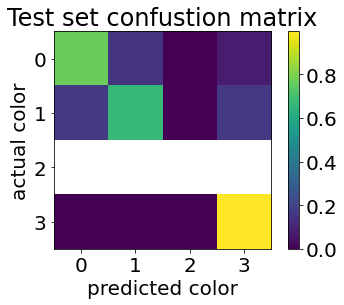

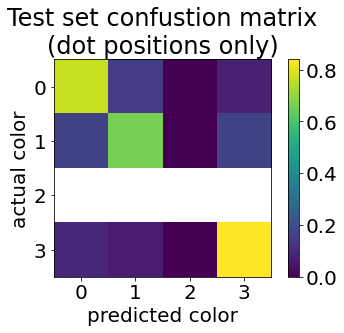

Test set confusion matrix data:
tensor([[0.7692, 0.1538, 0.0000, 0.0769],
        [0.1667, 0.6667, 0.0000, 0.1667],
        [   nan,    nan,    nan,    nan],
        [0.0014, 0.0010, 0.0000, 0.9976]], device='cuda:0')
Test set confusion matrix data (dot positions only):
tensor([[0.7692, 0.1538, 0.0000, 0.0769],
        [0.1667, 0.6667, 0.0000, 0.1667],
        [   nan,    nan,    nan,    nan],
        [0.0943, 0.0662, 0.0000, 0.8394]], device='cuda:0')
Test set unnormalized confusion matrix data:
tensor([[4.9000e+02, 9.8000e+01, 0.0000e+00, 4.9000e+01],
        [4.9000e+01, 1.9600e+02, 0.0000e+00, 4.9000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.4500e+02, 1.7200e+02, 0.0000e+00, 1.7152e+05]], device='cuda:0')
Test set unnormalized confusion matrix data (dot positions only):
tensor([[ 490.,   98.,    0.,   49.],
        [  49.,  196.,    0.,   49.],
        [   0.,    0.,    0.,    0.],
        [ 245.,  172.,    0., 2180.]], device='cuda:0')
Grid tallyin

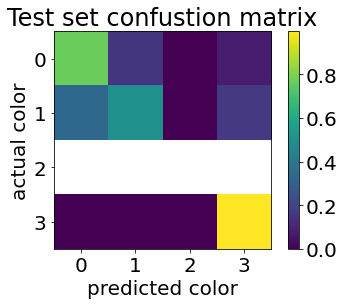

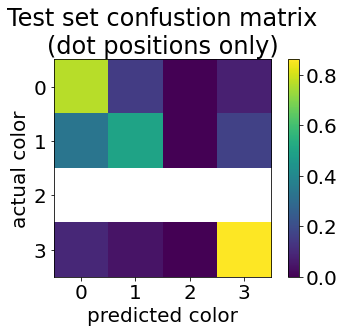

Test set confusion matrix data:
tensor([[7.6923e-01, 1.5385e-01, 0.0000e+00, 7.6923e-02],
        [3.3333e-01, 5.0000e-01, 0.0000e+00, 1.6667e-01],
        [       nan,        nan,        nan,        nan],
        [1.4249e-03, 6.8628e-04, 0.0000e+00, 9.9789e-01]], device='cuda:0')
Test set confusion matrix data (dot positions only):
tensor([[0.7692, 0.1538, 0.0000, 0.0769],
        [0.3333, 0.5000, 0.0000, 0.1667],
        [   nan,    nan,    nan,    nan],
        [0.0943, 0.0454, 0.0000, 0.8602]], device='cuda:0')
Test set unnormalized confusion matrix data:
tensor([[4.9000e+02, 9.8000e+01, 0.0000e+00, 4.9000e+01],
        [9.8000e+01, 1.4700e+02, 0.0000e+00, 4.9000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.4500e+02, 1.1800e+02, 0.0000e+00, 1.7158e+05]], device='cuda:0')
Test set unnormalized confusion matrix data (dot positions only):
tensor([[ 490.,   98.,    0.,   49.],
        [  98.,  147.,    0.,   49.],
        [   0.,    0.,    0.,    0.],
    

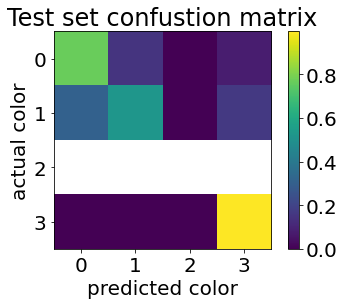

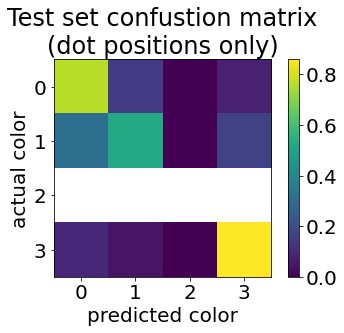

Test set confusion matrix data:
tensor([[7.6923e-01, 1.5071e-01, 0.0000e+00, 8.0063e-02],
        [3.0952e-01, 5.2381e-01, 0.0000e+00, 1.6667e-01],
        [       nan,        nan,        nan,        nan],
        [1.4249e-03, 7.0373e-04, 0.0000e+00, 9.9787e-01]], device='cuda:0')
Test set confusion matrix data (dot positions only):
tensor([[0.7692, 0.1507, 0.0000, 0.0801],
        [0.3095, 0.5238, 0.0000, 0.1667],
        [   nan,    nan,    nan,    nan],
        [0.0943, 0.0466, 0.0000, 0.8591]], device='cuda:0')
Test set unnormalized confusion matrix data:
tensor([[4.9000e+02, 9.6000e+01, 0.0000e+00, 5.1000e+01],
        [9.1000e+01, 1.5400e+02, 0.0000e+00, 4.9000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.4500e+02, 1.2100e+02, 0.0000e+00, 1.7158e+05]], device='cuda:0')
Test set unnormalized confusion matrix data (dot positions only):
tensor([[ 490.,   96.,    0.,   51.],
        [  91.,  154.,    0.,   49.],
        [   0.,    0.,    0.,    0.],
    

In [22]:
LossTest = namedtuple('LossTest', ['name', 'fctn', 'num_epochs'])
losses = [
    LossTest('mle',      mle,          20),
    LossTest('balanced', mle_balanced, 20),
    LossTest('dot',      mle_dot,      20),
    LossTest('radial',   mle_radial,   20)]
models = {}
def testall():
    pretrained = True
    save_path = './resources/exp_1_4/{model}_{loss}_loss_model_save'
    for loss in losses:
        model = copy.deepcopy(edited_resnet_model).to(device)
        if pretrained:
            model.load_state_dict(torch.load(save_path.format(model=model_name, loss=loss.name)))
        else:
            if not loss.num_epochs:
                continue
            print(f"Testing loss: {loss.name}")
            # Observe that all parameters are being optimized
            optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
            # Decay LR by a factor of 0.1 every 7 epochs
            exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.9)
            model = train_model(model, loss.fctn, optimizer_ft, exp_lr_scheduler, 
                                num_epochs=loss.num_epochs)
            torch.save(model.state_dict(), save_path.format(model=model_name, loss=loss.name))
        models[loss.name] = model
        test_model(models[loss.name])
testall()

Interesting examples:



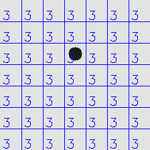
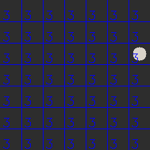
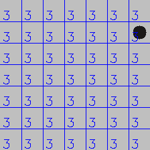
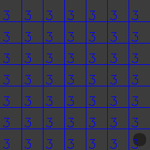
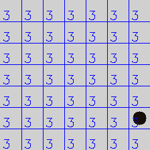
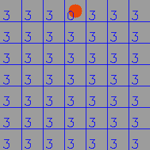
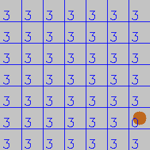
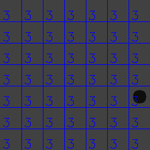


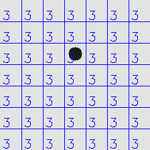
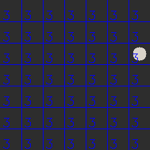
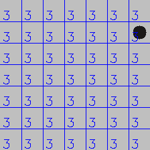
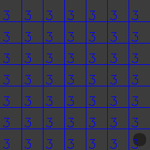
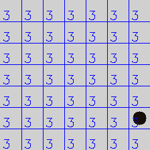
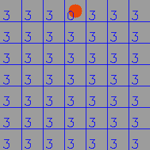
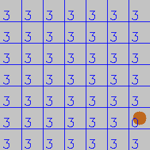
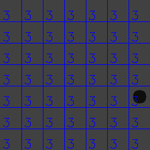

Other examples:
(Tab by correct label. The grids are the model outputs)



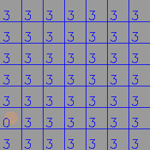
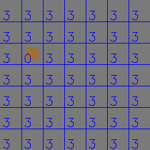
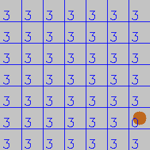
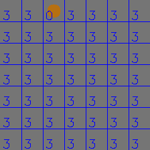
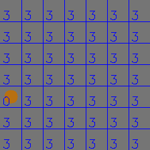
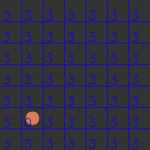
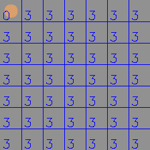
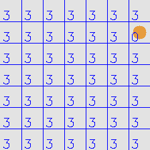
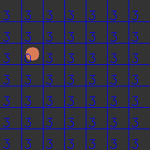
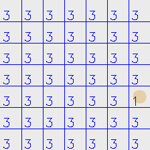
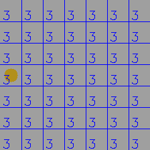
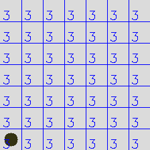
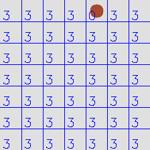
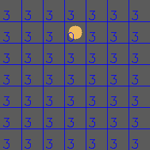
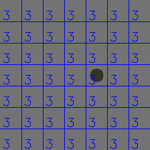
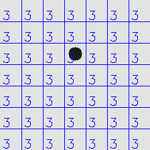
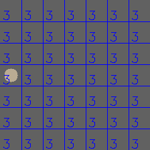
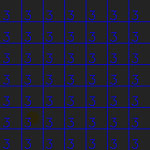
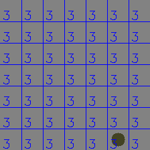
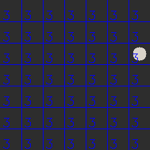
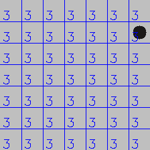
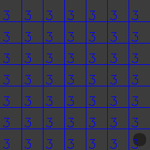
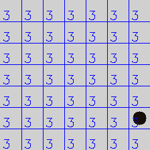
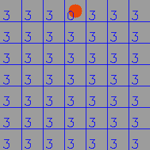
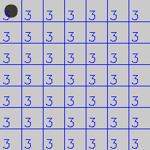
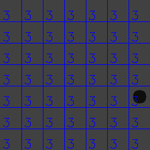
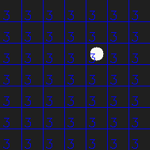
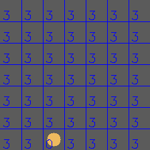
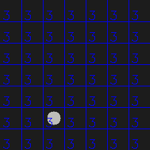
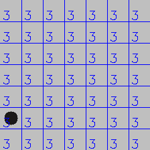
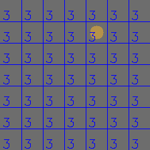
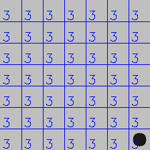
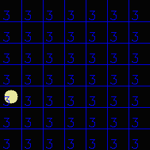
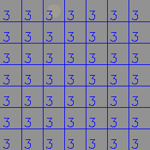
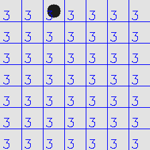
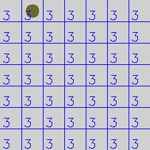
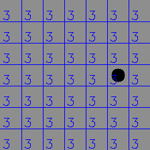
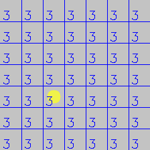
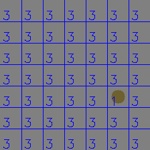
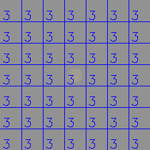
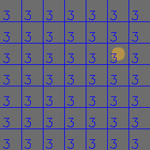
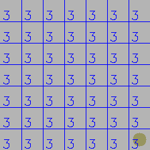
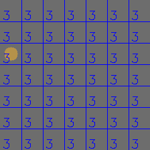
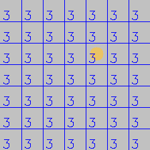
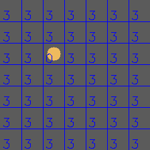
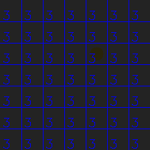
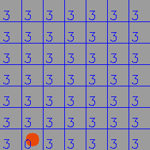
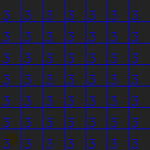
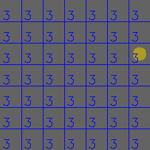
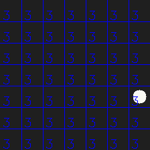


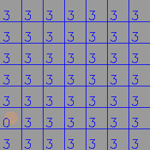
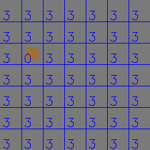
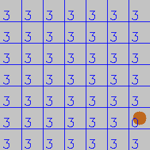
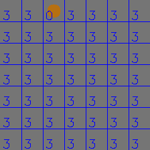
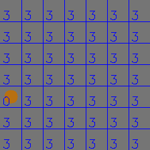
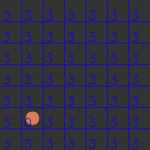
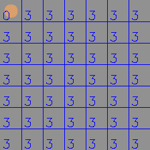
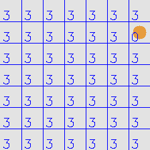
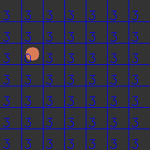
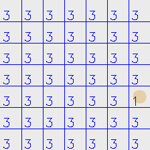
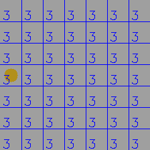
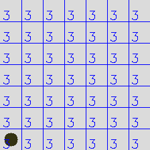
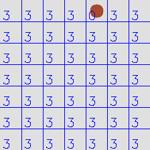
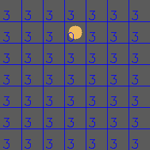
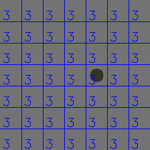
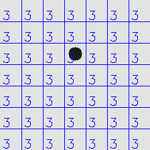
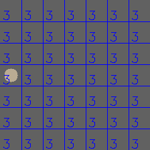
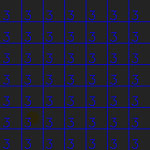
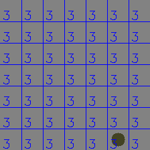
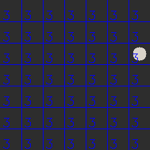
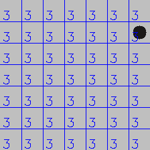
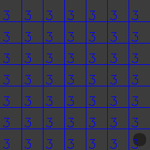
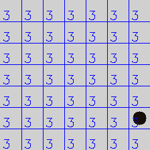
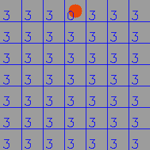
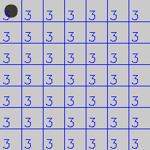
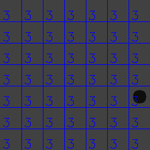
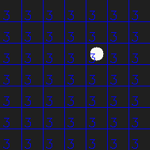
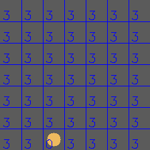
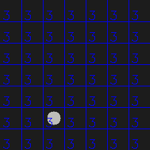
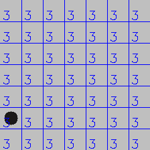
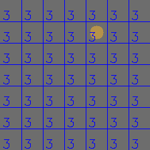
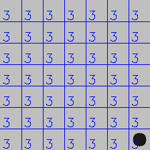
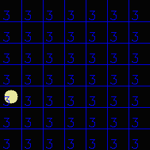
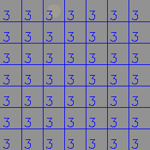
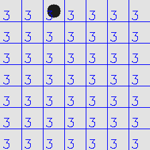
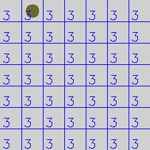
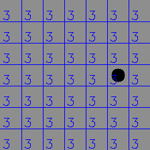
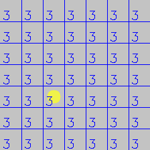
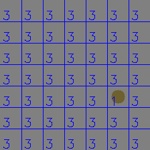
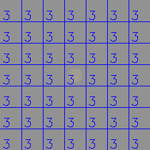
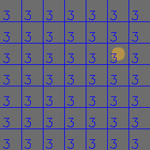
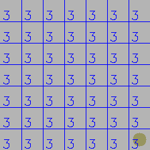
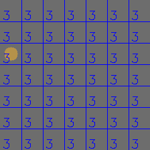
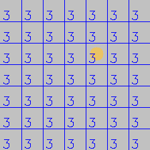
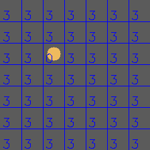
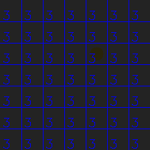
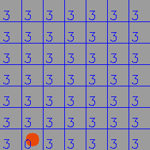
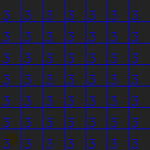
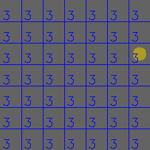
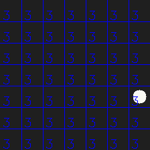

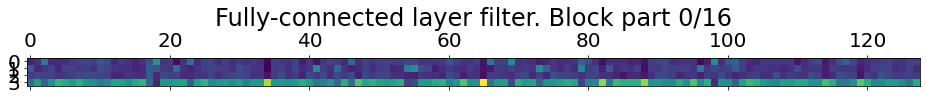

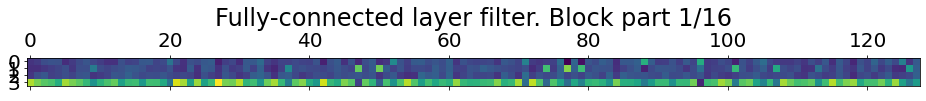

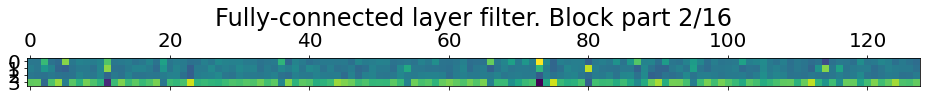

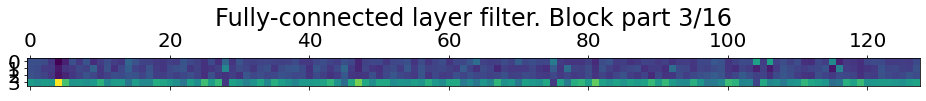

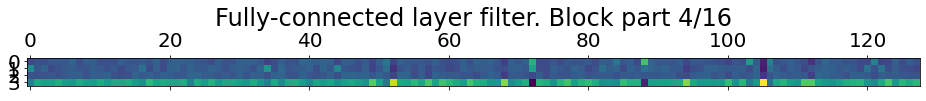

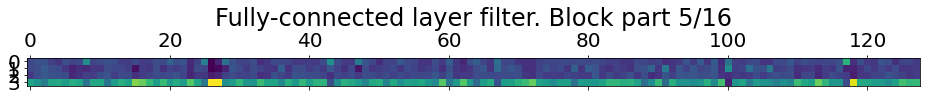

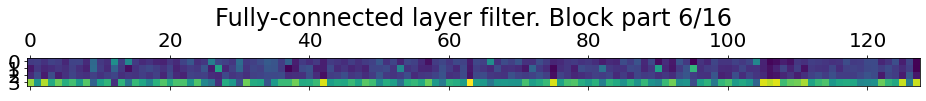

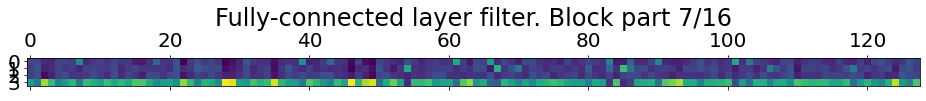

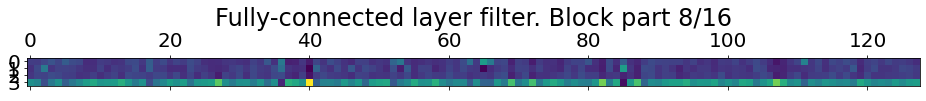

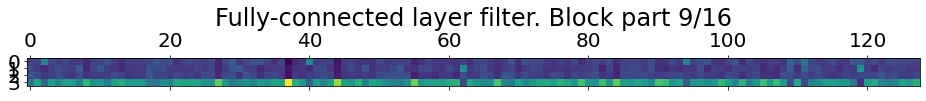

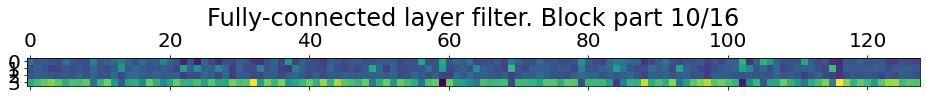

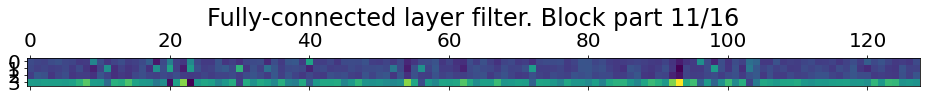

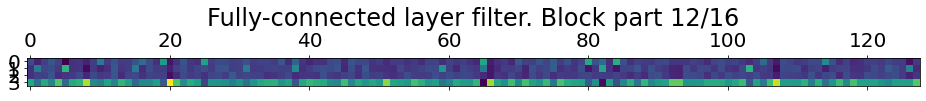

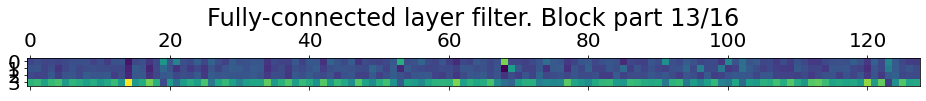

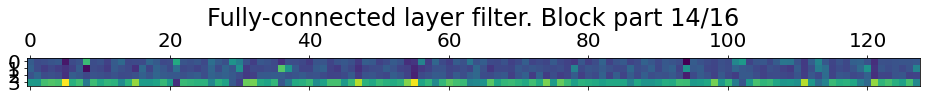

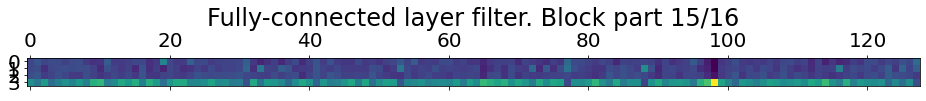

In [23]:
# Investigate one of the models in more detail.
debug_model(models['radial'])
test_ds._labelled_colors.sort(key=lambda a:a[0])

## 9. Results
Low accuracy is some evidence to suggest that no enough information reaches the neurons in the target layer. However, there are a number of reasons why this evidence is quite weak.

## 9.1 Experiment issues
I have a number of concerns:

1. the dataset feels very small. This became especially obvious once the test set was shaved off and brown getting only XX different color codes.
2. I don't have any evidence that my mapping between dots and activations is effective. I need to check which image pixels feed into which activations, and to try place dots in the center of these calculated windows. A poor correspondence could result in the filter needing to locate orange/brown in a different position relative to its window depending on which activation it is calculating.
3. the distinction of orange/brown relies to relative brightnesses, and so, it seems likely that the size of the center dot is important. I have scaled down the dot without checking to see if the dataset classifications are affected.
4. The model uses MLE via softmax activations. Nothing inherently wrong with this choice; however, it doesn't take advantage of an important assumption: I think orange and brown can be linearly separable on a single dimension. Projecting the 2048 features (or 512 for resnet18) onto two dimensions (weight + bias) might constrain the model in a useful way. If high accuracy can be achieved under this constraint, then this might be used to reverse engineer the model to extract a color dimension (the dimension for "related" colors). 

## 10. Next steps
Some useful investigations to do next:

1. find a model for orange/brown such that we can generate the color pairs more freely, without being restricted to the dataset. This tackles issue #1 above.
2. Investigate the window of the input image that contributes to each activation. This tackles issue #2 above.
3. Another way of investigating issue #2 is to restrict the classification to only 1 of the 49 activations and then check what accuracy we get. Extend 1 to 3x3 then 4x4 etc.
we have 99% accuracy. Looking at the accuracy metric shows that it's not very useful: an accuracy of 48/49=98% can be achieved by just returning 0 for every square. To get a better idea of the performance, let's take a look at some specific examples.
4. Implement an alternative dataset, such as red-blue color distinction. This dataset will be useful to form a comparison and to help find any possible bugs.
5. Follow up of issue #4.